In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import itertools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sampl.gsn_api as gsn
import sampl.semantics as sem
import sampl.update as update
import sampl.gsn_plot as gsn_plot

In [8]:
def plot_frame(op, activations_input, font_size=22, title_font_size=26, titles=True, dpi=300, save_path=None):
    sns.set(font_scale=1)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
    gsn_plot.plot_op_network(
        op, 
        font_size=font_size, 
        ax=ax1
    )
    if titles:
        ax1.set_title("Initial state\n", fontsize=title_font_size)

    plot_activations_a = {}
    for i, label in enumerate(op.graph.labels):
        if activations_input[i] > 0:
            plot_activations_a[label] = float(activations_input[i])
    gsn_plot.plot_op_network(
        op, 
        activations=plot_activations_a, 
        font_size=font_size, 
        ax=ax2
    )
    if titles:
        ax2.set_title("Activation\n", fontsize=title_font_size)

    activations_recur = gsn.spread_recur(
        op.graph.adj, activations_input, op.update_fx, op.discount, debug=False
    )
    print(f"activations_recur: {activations_recur}")
    plot_activations_b = {}
    for i, label in enumerate(op.graph.labels):
        if activations_recur[i] > 0:
            plot_activations_b[label] = float(activations_recur[i])
    previous_adj = op.graph.adj
    op.activate_replace(activations_input)
    adj_change = op.graph.adj - previous_adj

    edge_change_keys = list(itertools.combinations(op.graph.labels, 2))
    edge_change = {}
    for key in edge_change_keys:
        i_from = op.graph.labels.index(key[0])
        i_to = op.graph.labels.index(key[1])
        val = np.round(adj_change[i_from, i_to], 2)
        edge_change[key] = val
    
    gsn_plot.plot_op_network(
        op, 
        activations=plot_activations_b, 
        custom_edges=edge_change, 
        draw_edge_colors=True, 
        font_size=font_size, 
        ax=ax3
    )
    if titles:
        ax3.set_title("Spreading activation \n& weight change", fontsize=title_font_size)

    gsn_plot.plot_op_network(
        op, 
        font_size=font_size, 
        ax=ax4
    )
    if titles:
        ax4.set_title("Final state\n", fontsize=title_font_size)
    if save_path:
        plt.subplots_adjust(top=0.88)
        plt.savefig(save_path, transparent=True, dpi=dpi)

In [9]:
fruit_adj = np.zeros((3, 3))
#fruit_labels = ['apple', 'bus', 'cat']
fruit_labels = [' ', '  ', '   ']
fruit_graph = sem.SemanticGraph(fruit_adj, fruit_labels)

fruit_update = update.get_update(
    dip_center=.15,
    dip_width=.4,
    y_min=-.1,
    y_max=.5
)

fruit_op = gsn.GraphOperator(
    graph=fruit_graph, 
    operate_fx=gsn.operate_recur,
    update_fx=fruit_update,
    discount=.3
)

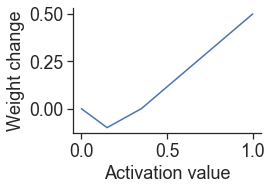

In [10]:
sns.set(font_scale=1.6, style='ticks')
xs = np.linspace(0, 1., 101)
ys = fruit_update(xs)
fig, ax = plt.subplots(figsize=[4,3])
plt.plot(xs, ys)
plt.xlabel('Activation value', fontsize=18)
plt.ylabel('Weight change', fontsize=18)
plt.title('', fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('worked_example_weight_update.png', dpi=300)

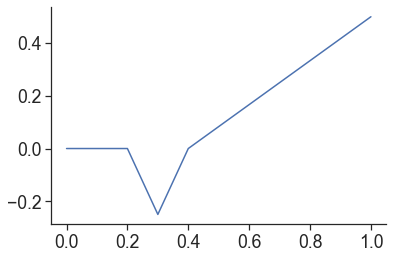

In [11]:
fig, ax = plt.subplots()
ax.plot([0, .2, .3, .4, 1], [0, 0, -.25, 0, .5])
sns.despine()
plt.savefig('weight_update_demo.png', dpi=300)

activations_recur: [1 1 0]


/Users/beau/miniconda3/envs/latest/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/beau/miniconda3/envs/latest/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/beau/miniconda3/envs/latest/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


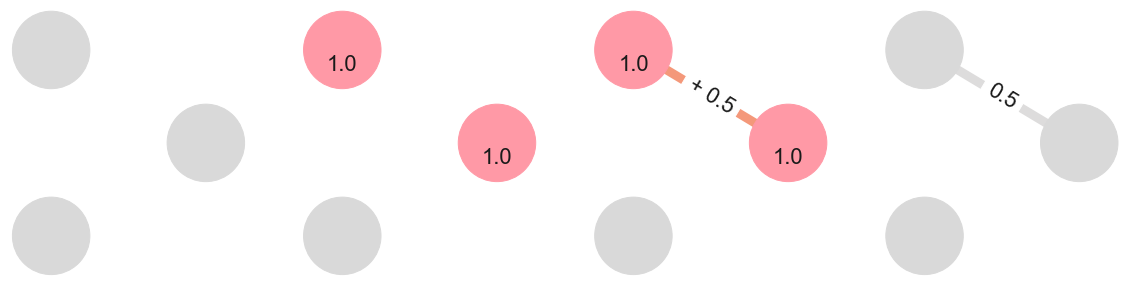

In [12]:
plot_frame(fruit_op, np.array([1, 1, 0]), titles=False, save_path="demo_01.png")

An artificial semantic network with three nodes (apple, banana, and coconut) and no edges. The apple and banana nodes are activated simultaneously. Because there are no edges, no activation is propagated to the coconut node. The minimum activation value of the activated nodes is 1.0, so the weight of the edge between them is changed by nmp(1.0) = .5.

activations_recur: [0.15 1.   1.  ]


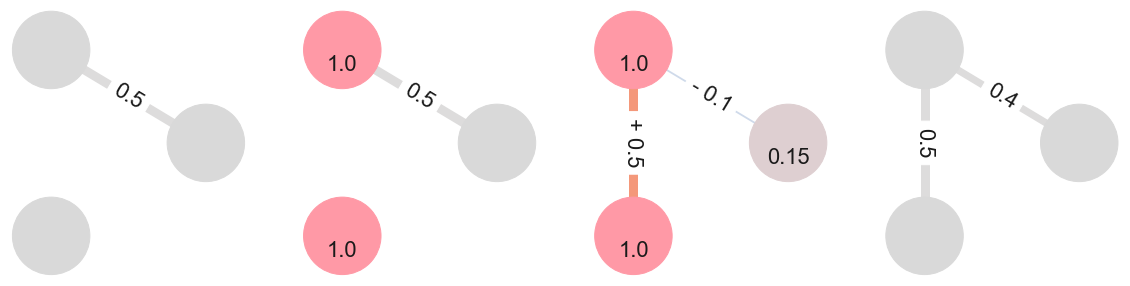

In [13]:
plot_frame(fruit_op, np.array([0, 1, 1]), titles=False, save_path="demo_02.png")

Next, the banana and coconut nodes are activated simultaneously. The activation that propagates to the apple node is equal to the activation at the banana node \* the discount factor \* the edge weight, or 1.0 \* 0.3 \* 0.5 = 0.15. The activation at the banana and coconut nodes is 1.0, so the edge between them is incremented by nmp(1.0) = .5. The minimum activation of the banana and apple nodes is 0.15 (at the apple node). This is in the "zone of destruction," so the edge between them is changed by nmp(0.15) = -.1, causing retrieval-induced forgetting.

activations_recur: [0.12 1.   1.  ]


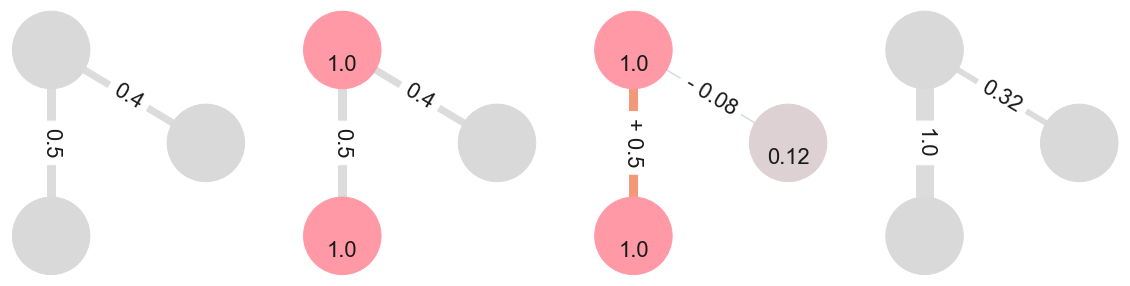

In [14]:
plot_frame(fruit_op, np.array([0, 1, 1]), titles=False, save_path="demo_03.png")

Simultaneously activating the banana and coconut nodes a second time results in further reinforcement of the edge between them, as well as further forgetting along the edge from the banana node to the apple node.

activations_recur: [1.    0.396 1.   ]


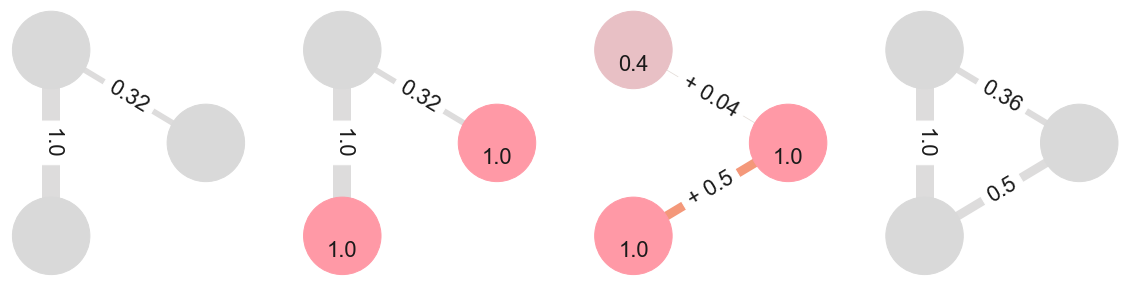

In [15]:
plot_frame(fruit_op, np.array([1, 0, 1]), titles=False, save_path="demo_04.png")